In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

p = np.load('alice_mc_lorentz_jets_80_90.npy', mmap_mode='r')
labels = np.load('alice_mc_labels_80_90.npy', mmap_mode='r')
R=1
def notzero(i):
    N=0
    m=p[i][0:][0:]
    while True:
        N=N+1
        if m[N][0]<0.000001:
            break
    return p[i][0:N][0:]
        

def update(m):
    y=[0.5*math.log((m[i][0]+m[i][3])/(m[i][0]-m[i][3])) for i in range(m.shape[0])]
    pt=[np.sqrt(m[i][1]**2+m[i][2]**2) for i in range(m.shape[0])]
    azimut=[math.acos(m[i][1]/pt[i]) for i in range(m.shape[0])]
    global d
    d=np.ndarray((m.shape[0],m.shape[0]))
    for i in range(m.shape[0]):
        for j in range(m.shape[0]):
            d[i][j]=((y[i]-y[j])**2+(azimut[j]-azimut[i])**2)/R**2
        
def minimum(m):
    k=0
    l=1
    mini=m[0][1]
    for i in range(0,m.shape[0]):
        for j in range(i+1,m.shape[0]):
            if m[i][j]<mini:
                mini=m[i][j]
                k=i
                l=j
    return [k,l,mini]


def cluster(m):
    t=minimum(d)
    čestica1=t[0]
    čestica2=t[1]
    if čestica1>čestica2:
        r=čestica1
        čestica1=čestica2
        čestica2=r
    n=np.shape(m)
    b=np.ndarray((n[0]-1,4))
    s=m[čestica1]+m[čestica2]
    i=0
    j=0
    while i<m.shape[0]:
        if i==čestica1:
            b[j][:]=s
            i=i+1
            j=j+1
        elif i==čestica2:
            if i<m.shape[0]-1:
                b[j][:]=m[i+1][:]
            else:
                break
            i=i+2
            j=j+1
        else:
            b[j][:]=m[i][:]
            i=i+1
            j=j+1
    return b
                



In [4]:
def recluster(m):
    update(m)
    x=[]
    D=[]
    x.append(m)
    D.append(d)
    for i in range(m.shape[0]-1):
        m=cluster(m)
        update(m)
        x.append(m)
        D.append(d)
    return (x,D)

def decluster(x,D):
    n=len(x)
    ps=[]
    ips=[]
    L=[]
    i=n-2
    čes=0
    #pcut=1000
    while i>=0:
        m=minimum(D[i])
        čestica1=m[0]
        čestica2=m[1]
        if čestica2<čestica1:
            r=čestica1
            čestica1=čestica2
            čestica2=r
        if čes==čestica1:
            pt1=np.sqrt(x[i][čestica1][1]**2+x[i][čestica1][2]**2)
            pt2=np.sqrt(x[i][čestica2][1]**2+x[i][čestica2][2]**2)
            ps.append(min(pt1,pt2))
            #if pt1<pcut or pt2<pcut:
                #break
            if pt1<pt2:
                L.append([pt1*m[2],m[2],pt2*m[2]])
                čes=čestica2
                ips.append(čestica1)
            else:
                L.append([pt2*m[2],m[2],pt1*m[2]])
                čes=čestica1
                ips.append(čestica2)
        else:
            if čes<čestica2:
                pass
            else:
                čes=čes+1
            ips.append(-1)
            ps.append(-1)
        i=i-1
    global ind
    if len(ps):
        sec=np.max(ps)
        ind=ps.index(sec)
        ps[ind]=-1
    else:
        ind=len(x)
    global ind2 
    if len(ps):
        ter=np.max(ps)
        ind2=ps.index(ter)
    else:
        ind2=len(x)
    global indx
    indx=ips[ind]
    global indx2
    indx2=ips[ind2]
    return L





    
        
def secl(x,D,čess):
    n=len(x)
    L=[]
    i=n-3
    čes=čess
    #pcut=1000
    while i>=0:
        m=minimum(D[i])
        čestica1=m[0]
        čestica2=m[1]
        if čestica2<čestica1:
            r=čestica1
            čestica1=čestica2
            čestica2=r
        if čes==čestica1:
            pt1=np.sqrt(x[i][čestica1][1]**2+x[i][čestica1][2]**2)
            pt2=np.sqrt(x[i][čestica2][1]**2+x[i][čestica2][2]**2)
            #if pt1<pcut or pt2<pcut:
                #break
            if pt1<pt2:
                L.append([pt1*m[2],m[2],pt2*m[2]])
                čes=čestica2
            else:
                L.append([pt2*m[2],m[2],pt1*m[2]])
                čes=čestica1
        else:
            if čes<čestica2:
                pass
            else:
                čes=čes+1
        i=i-1
    return L
    
    


        
    
    

In [1]:
def pad_image(image, max_size = (14,14)):
    """
    Simply pad an image with zeros up to max_size.
    """
    size = np.shape(image)
    xs=np.zeros(shape=(size[0],1))
    ys=np.zeros(shape=(1,max_size[1]))
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    for i in range(int(np.floor(px/2.0))):
        image=np.hstack((xs,image))
    for i in range(int(np.ceil(px/2.0))):
        image=np.hstack((image,xs))
    for i in range(int(np.floor(py/2.0))):
        image=np.vstack((ys,image))
    for i in range(int(np.ceil(py/2.0))):
        image=np.vstack((image,ys))
    return image


In [14]:
q=0
g=0
j=0
LL=[]
lb=[]
while j<80000:   
    x,D=recluster(notzero(j))
    L1=decluster(x,D)
    k1=[np.log(L1[i][0]) for i in range(len(L1))]
    d1=[np.log(1/L1[i][1]) for i in range(len(L1))]
    z=[L1[i][0]/(L1[i][0]+L1[i][2]) for i in range(len(L1))]
    yedges=[k1[i] for i in range(len(L1))]
    xedges=[d1[i] for i in range(len(L1))]
    if len(L1):
        hist,xedges,yedges=np.histogram2d(xedges,yedges,bins=len(L1),weights=z)
    else:
        j=j+1
        continue
    hist=(hist/np.max(hist)*255).astype(int)
    
    L2=secl(x[0:-ind],D[0:-ind],indx)
    k2=[np.log(L2[i][0]) for i in range(len(L2))]
    d2=[np.log(1/L2[i][1]) for i in range(len(L2))]
    z2=[L2[i][0]/(L2[i][0]+L2[i][2]) for i in range(len(L2))]
    yedges=[k2[i] for i in range(len(L2))]
    xedges=[d2[i] for i in range(len(L2))]
    hist2,xedges,yedges=np.histogram2d(xedges,yedges,bins=len(L1),weights=z2)
    if np.max(hist2):
        hist2=(hist2/np.max(hist2)*255).astype(int)
    
    hist=np.dstack((pad_image(hist),pad_image(hist2)))
    
    L3=secl(x[0:-ind2],D[0:-ind2],indx2)
    k3=[np.log(L3[i][0]) for i in range(len(L3))]
    d3=[np.log(1/L3[i][1]) for i in range(len(L3))]
    z3=[L3[i][0]/(L3[i][0]+L3[i][2]) for i in range(len(L3))]
    yedges=[k3[i] for i in range(len(L3))]
    xedges=[d3[i] for i in range(len(L3))]
    hist3,xedges,yedges=np.histogram2d(xedges,yedges,bins=len(L1),weights=z3)
    if np.max(hist3):
        hist3=(hist3/np.max(hist3)*255).astype(int)
    
    hist=np.dstack((hist,pad_image(hist3)))
    
    LL.append(hist)
    
    
    if labels[j]==0:
        lb.append(labels[j])
        q=q+1
    if labels[j]==1:
        lb.append(labels[j])
        g=g+1
    j=j+1
    if q>=g:
        while labels[j]!=1:
            j=j+1

In [15]:
q=0
g=0
j=500000
LLv=[]
lbv=[]
while j<600000:   
    x,D=recluster(notzero(j))
    L1=decluster(x,D)
    k1=[np.log(L1[i][0]) for i in range(len(L1))]
    d1=[np.log(1/L1[i][1]) for i in range(len(L1))]
    z=[L1[i][0]/(L1[i][0]+L1[i][2]) for i in range(len(L1))]
    yedges=[k1[i] for i in range(len(L1))]
    xedges=[d1[i] for i in range(len(L1))]
    hist,xedges,yedges=np.histogram2d(xedges,yedges,bins=len(L1),weights=z)
    hist=(hist/np.max(hist)*255).astype(int)
    
    L2=secl(x[0:-ind],D[0:-ind],indx)
    k2=[np.log(L2[i][0]) for i in range(len(L2))]
    d2=[np.log(1/L2[i][1]) for i in range(len(L2))]
    z2=[L2[i][0]/(L2[i][0]+L2[i][2]) for i in range(len(L2))]
    yedges=[k2[i] for i in range(len(L2))]
    xedges=[d2[i] for i in range(len(L2))]
    hist2,xedges,yedges=np.histogram2d(xedges,yedges,bins=len(L1),weights=z2)
    if np.max(hist2):
        hist2=(hist2/np.max(hist2)*255).astype(int)
    
    hist=np.dstack((pad_image(hist),pad_image(hist2)))
    
    L3=secl(x[0:-ind2],D[0:-ind2],indx2)
    k3=[np.log(L3[i][0]) for i in range(len(L3))]
    d3=[np.log(1/L3[i][1]) for i in range(len(L3))]
    z3=[L3[i][0]/(L3[i][0]+L3[i][2]) for i in range(len(L3))]
    yedges=[k3[i] for i in range(len(L3))]
    xedges=[d3[i] for i in range(len(L3))]
    hist3,xedges,yedges=np.histogram2d(xedges,yedges,bins=len(L1),weights=z3)
    if np.max(hist3):
        hist3=(hist3/np.max(hist3)*255).astype(int)
    
    hist=np.dstack((hist,pad_image(hist3)))
    
    LLv.append(hist)
    
    if labels[j]==0:
        lbv.append(labels[j])
        q=q+1
    if labels[j]==1:
        lbv.append(labels[j])
        g=g+1
    j=j+1
    if q>=g:
        while labels[j]!=1:
            j=j+1

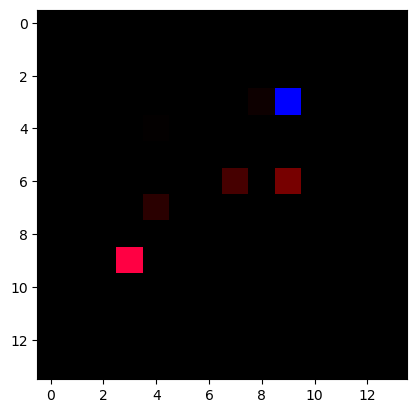

In [32]:
plt.imshow(LL[5]/np.max(LL[5]))

In [16]:
def qg(i):
    m=labels[i]
    return m

    
    
    


In [17]:
import pickle
pickle.dump( LL, open( "trainsec.pkl", "wb" ) )
pickle.dump( lb, open( "trainseclabels.pkl", "wb" ) )
pickle.dump( LLv, open( "valssec.pkl", "wb" ) )
pickle.dump( lbv, open( "valsseclabels.pkl", "wb" ) )

In [18]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
batch_size = 40
train_ds=tf.data.Dataset.from_tensor_slices((LL,lb)).batch(batch_size)
val_ds=tf.data.Dataset.from_tensor_slices((LLv,lbv)).batch(batch_size)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
img_height=14
img_width=14

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width,3)),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),    
  layers.MaxPooling2D(),
    layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64,3,padding='same',activation='relu'),
  layers.MaxPooling2D(),
    layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(300, activation='relu'),
    layers.Dropout(0.25),
  layers.Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 14, 14, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                        

In [25]:
model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001),metrics=['accuracy'])
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("model_history_sec.csv", append=True)

In [26]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [27]:
epochs=30
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, mode='min', verbose=1,patience=7)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[es,csv_logger]
)

Epoch 1/30
3400/3400 [==============================] - 291s 85ms/step - loss: 0.6869 - accuracy: 0.5503 - val_loss: 0.6756 - val_accuracy: 0.5831
Epoch 2/30
3400/3400 [==============================] - 338s 99ms/step - loss: 0.6740 - accuracy: 0.5835 - val_loss: 0.6696 - val_accuracy: 0.5897
Epoch 3/30
3400/3400 [==============================] - 298s 88ms/step - loss: 0.6704 - accuracy: 0.5900 - val_loss: 0.6679 - val_accuracy: 0.5967
Epoch 4/30
3400/3400 [==============================] - 332s 98ms/step - loss: 0.6690 - accuracy: 0.5920 - val_loss: 0.6669 - val_accuracy: 0.5990
Epoch 5/30
3400/3400 [==============================] - 293s 86ms/step - loss: 0.6680 - accuracy: 0.5933 - val_loss: 0.6661 - val_accuracy: 0.5997
Epoch 6/30
3400/3400 [==============================] - 302s 89ms/step - loss: 0.6673 - accuracy: 0.5945 - val_loss: 0.6655 - val_accuracy: 0.6005
Epoch 7/30
3400/3400 [==============================] - 328s 96ms/step - loss: 0.6665 - accuracy: 0.5970 - val_loss: 0

In [28]:
model.save("modelsecodary")

INFO:tensorflow:Assets written to: modelsecodary\assets


INFO:tensorflow:Assets written to: modelsecodary\assets


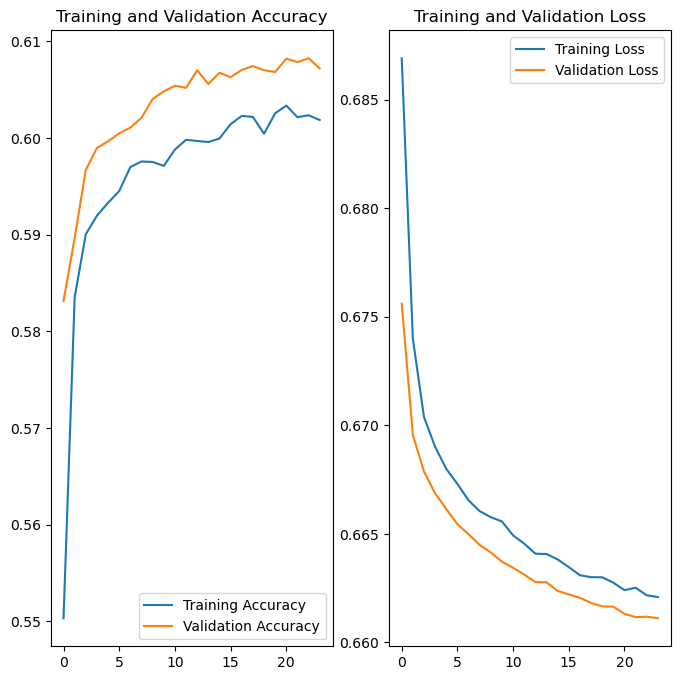

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [123]:
rapidities=[]
azimuts=[]
def rapazi(m):
    global y
    y=[0.5*math.log((m[i][0]+m[i][3])/(m[i][0]-m[i][3])) for i in range(m.shape[0])]
    pt=[np.sqrt(m[i][1]**2+m[i][2]**2) for i in range(m.shape[0])]
    global azimut
    azimut=[math.acos(m[i][1]/pt[i]) for i in range(m.shape[0])]
    
    

for j in range(10000):
    if qg(j)==0:
        rapazi(notzero(j))
        rapidities=rapidities+y
        azimuts=azimuts+azimut
    



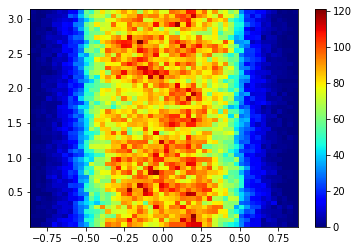

In [124]:
z,xedges,yedges=np.histogram2d(rapidities,azimuts,50)
plt.pcolormesh(xedges,yedges,z.T,cmap='jet')
plt.colorbar()
plt.show()  

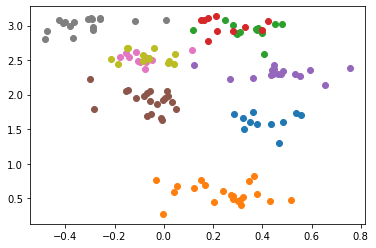

In [126]:
rapidities=[]
azimuts=[]
def rapazi(m):
    global y
    y=[0.5*math.log((m[i][0]+m[i][3])/(m[i][0]-m[i][3])) for i in range(m.shape[0])]
    pt=[np.sqrt(m[i][1]**2+m[i][2]**2) for i in range(m.shape[0])]
    global azimut
    azimut=[math.acos(m[i][1]/pt[i]) for i in range(m.shape[0])]
    
    

for j in range(10):
    if qg(j)==0:
        rapazi(notzero(j))
        plt.scatter(y,azimut)
    



plt.show() 